In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import os
import gc
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup


ModuleNotFoundError: No module named 'distance'

In [ ]:
df = pd.read_csv(r"D:\python\Quora Question Pair\Data_Set\train.csv")
print("Number of points:", df.shape[0])

In [9]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_quid1,freq_quid2,q1len,q2len
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66.0,57.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,4,51.0,88.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73.0,59.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50.0,65.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,3,76.0,39.0


In [10]:
df.info()  # Notice that Question1 column has 1 row empty and Question2 column has 2 rows empty or null 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 10 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
freq_quid1      404290 non-null int64
freq_quid2      404290 non-null int64
q1len           404289 non-null float64
q2len           404288 non-null float64
dtypes: float64(2), int64(6), object(2)
memory usage: 30.8+ MB


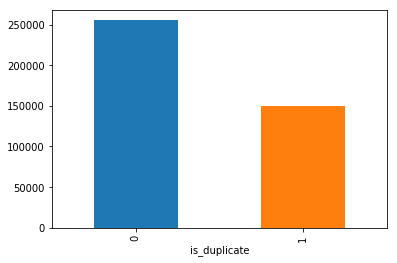

In [11]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [12]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


In [13]:
qids = pd.Series(df['qid1'].tolist() +df['qid2'].tolist())
unique_qs=len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print('Total number of Unique Questions are: {}\n'.format(unique_qs))

print("Number of unique questions that appear more than one time: {} ({}%)\n".format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print("Max Number of times a single question is repeated: {}\n".format(max(qids.value_counts())))

q_vals=qids.value_counts()
print(q_vals) # Pandas Index.value_counts() function returns object containing counts of unique values. 
#The resulting object will be in descending order so that the first element is the most frequently-occurring element. 
#Excludes NA values by default. Hence quid 2559 has occured most times ie 157
q_vals=q_vals.values
print(q_vals)

Total number of Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max Number of times a single question is repeated: 157

2559      157
30782     120
4044      111
2561       88
14376      79
17978      77
2675       68
28764      66
1772       63
24555      61
18753      58
4018       57
28133      56
3595       55
19621      55
18531      55
4951       55
13748      54
10024      54
10330      54
38         54
18296      53
11264      52
6551       52
20190      52
691        51
8461       51
6749       51
2322       51
33412      51
         ... 
95599       1
87403       1
259391      1
89450       1
1345        1
7490        1
13639       1
19784       1
17737       1
23882       1
32078       1
30031       1
34129       1
40274       1
38227       1
42325       1
48470       1
56666       1
54619       1
60764       1
64862       1
62815       1
66913       1
73058       1
77156       1
75109       1
81254       

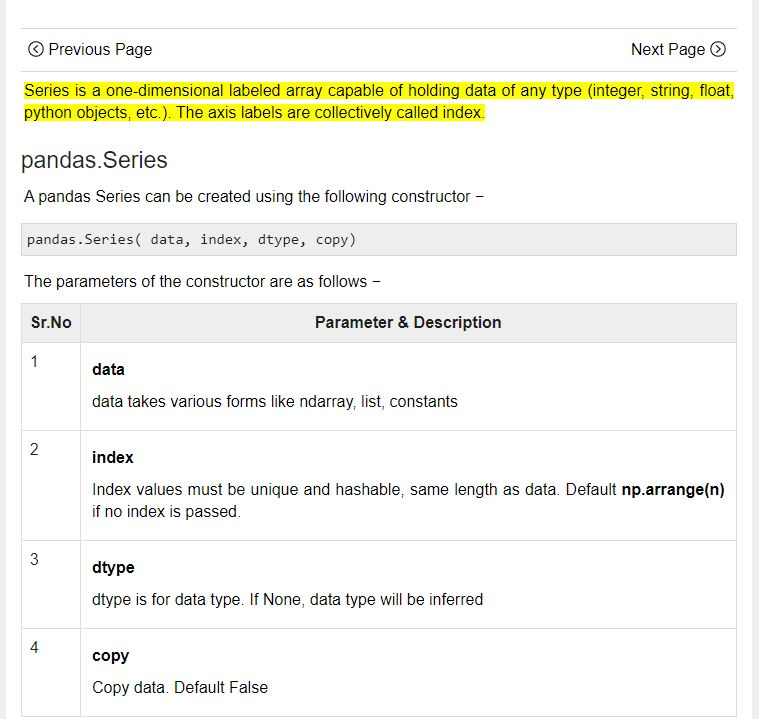

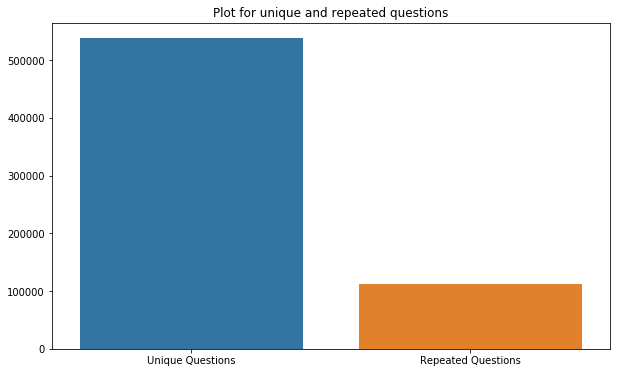

In [14]:
x=["Unique Questions","Repeated Questions"]
y=[unique_qs, qs_morethan_onetime]

plt.figure(figsize = (10,6)) # figsize is the widths and height in inches. Default is: [6.4, 4.8]
plt.title("Plot for unique and repeated questions")
sns.barplot(x,y)
plt.show()

# Checking for duplicates

In [15]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index() # find what reset index does here

print("Number of duplicates questions",(pair_duplicates).shape[0]-df.shape[0])

Number of duplicates questions 0


# Checking for null values

In [16]:
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  \
105780                                                NaN             0   
201841                                                NaN             0   
363362  My Chinese name is Haichao Yu. What English na...             0   

        freq_quid1  freq_quid2  q1len  q2len  
105780           2           2   30.0    NaN  
201841           1           1   32.0    NaN  
363362           1           1    NaN  123.0  


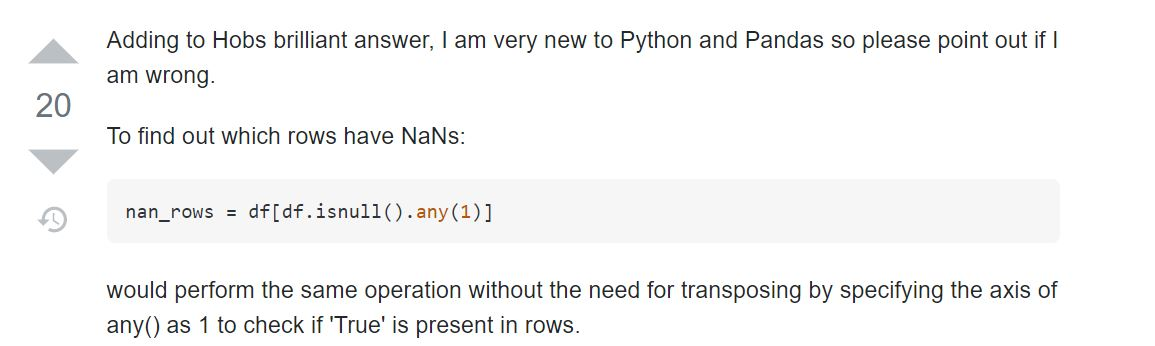

In [17]:
#filling the null values with a space or ' '
df=df.fillna(' ')
nan_rows=df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate, freq_quid1, freq_quid2, q1len, q2len]
Index: []


In [23]:
df['freq_qid1'] = df.groupby("qid1")["qid1"].transform('count') # see onenote transform for the meaning and use of transform function
df['freq_qid2'] = df.groupby("qid2")["qid2"].transform('count')
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row : len(row.split(" "))) # row is the variable which stores the question 1 by 1 so len(row.split(" ")) will give number of words 
df['q2_n_words'] = df['question2'].apply(lambda row : len(row.split(" ")))

def normalized_word_common(row): # row is any data frame
    w1 = set(map(lambda word : word.lower().strip(), row['question1'].split(" ")))  # map returns a list, so we convert it to set
    w2 = set(map(lambda word : word.lower().strip(), row['question1'].split(" ")))  # if you dont remove the null data then split will not work, I got an error that float does not have any funtion split()
    return 1.0 * len(w1 & w2)  # len of the new set which is an intersection of w1 and w2 or(w1 & w2) i.e it contains the word common to both w1 and w2
df['word_common'] = df.apply(normalized_word_common, axis=1)

def normalized_word_total(row):
    w1 = set(map(lambda word : word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word : word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_total,axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

df.to_csv("df_fe_without_preprocessing_train.csv", index= False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_quid1,freq_quid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_Total,word_share,freq_qid1,freq_qid2,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,12.0,23.0,0.434783,1,1,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,8.0,20.0,0.200000,4,1,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,14.0,24.0,0.166667,1,1,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,10.0,19.0,0.000000,1,1,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,13.0,20.0,0.100000,3,1,4,2


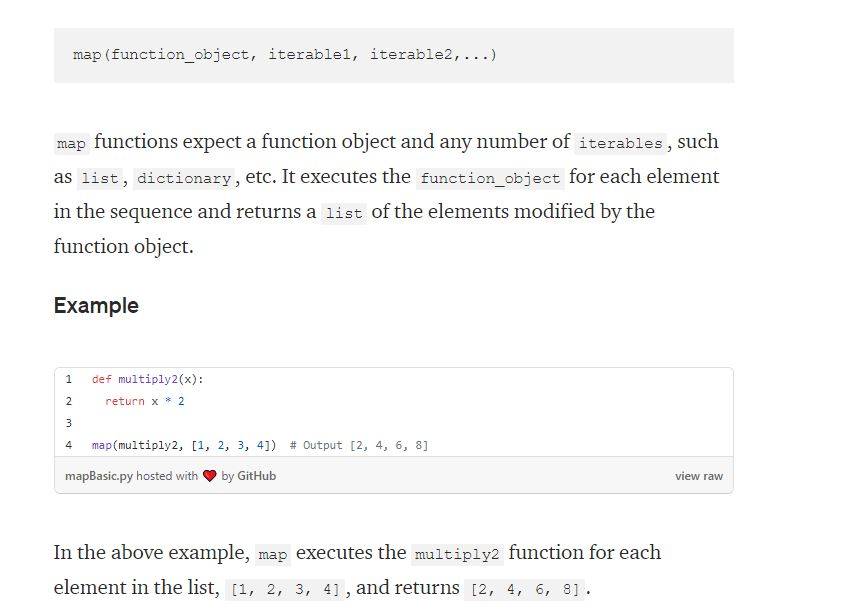

In [24]:
print ("Minimum length of the questions in question1 : ", min(df['q1_n_words']))
 
print ("Minimum length of hte questions in question2 : ", min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] : ", df[df['q1_n_words']==1].shape[0])
print ("Number of Questions with minimum length [question2] : ", df[df['q2_n_words']==1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of hte questions in question2 :  1
Number of Questions with minimum length [question1] :  66
Numner of Questions with minimum length [question2] :  22


In [2]:
df = pd.read_csv("df_fe_without_preprocessing_train.csv")

C:\Users\RISHAB MALLICK\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Users\RISHAB MALLICK\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



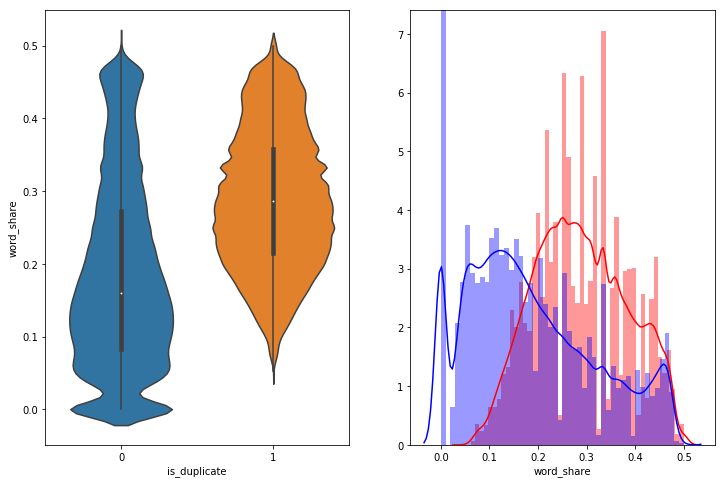

In [6]:
plt.figure(figsize =(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate',y='word_share',data =df[0:])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] ==1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] ==0.0]['word_share'][0:] , label = "0",color = "blue")
plt.show()

In [ ]:
# notice in the second graph the peaks of word share are higher for questions which are duplicate.
# No need to explain, it is quite understanding.

C:\Users\RISHAB MALLICK\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Users\RISHAB MALLICK\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



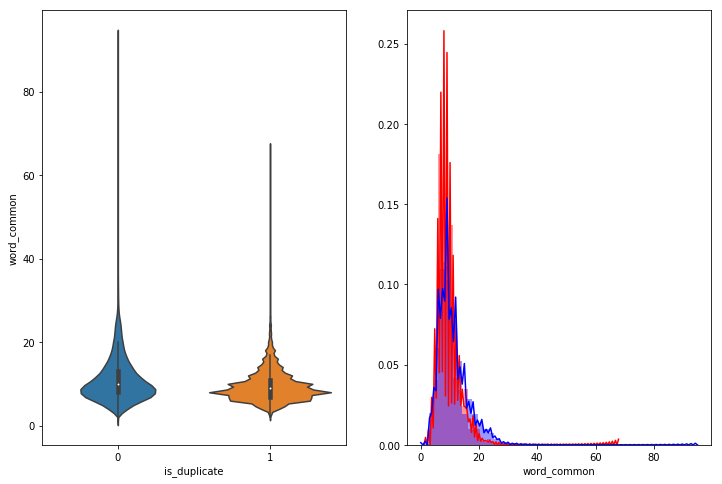

In [8]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_common'][0:] , label = "0" , color = 'blue' )
plt.show()

In [ ]:
# the graph is quite similar to word share but word share is more clear and readable.
# Also the in the violin plot the box plot part of both the classes are very close to each other in the y axis so not favourable